# "Basic panorama stitching"
> "We have a look at homographies and how they can be used to stitch photos into a panorama"

- toc: true
- badges: true
- comments: true
- categories: [computer-vision]
- author: Augustas Macijauskas
- image: images/city_panorama.png


In this notebook we will find that we can use knowledge of computer vision to create our own panoramas! We only need to take a few photos with a smartphone or camera, but we have to make sure that we only change the angle of the phone/camera, and not the position! This notebook then takes care of everything else.

> Note: Make sure the angles between photos are not too large since otherwise the algorithm can end up stretching some of the photos too much.

This notebook is based on the [Computer Vision course by Andreas Geiger](https://www.youtube.com/playlist?list=PL05umP7R6ij35L2MHGzis8AEHz7mg381_).

## Preliminaries

In [99]:
#hide

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pathlib import Path

Let's first import the some images that we want to stich together:

In [101]:
PATH_TO_YOUR_IMAGE = Path("path/to/your/images")

In [102]:
# Load images
images = sorted([f for f in PATH_TO_YOUR_IMAGE.iterdir()])
images = map(str, images)
images = map(cv2.imread, images)
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

len(images)

4

Let's have a look at the images:

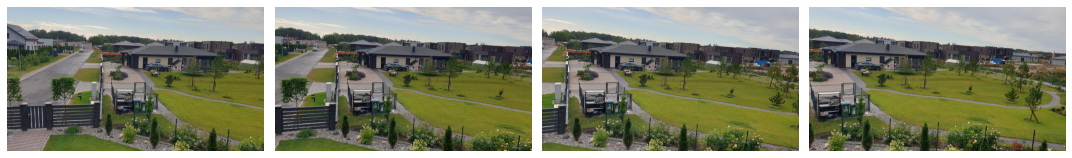

In [103]:
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for img, ax in zip(images, axes.flatten()):
    ax.imshow(img)
    ax.axis("off")

fig.tight_layout()
plt.show()

## Finding keypoints

To estimate the homography matrix, we need correspondence pairs between images. The following is a function for this based on feature matching:

In [104]:
def get_keypoints(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
    
    p_source = np.float32([keypoints1[good_match.queryIdx].pt for good_match in good]).reshape(-1, 2)
    p_target = np.float32([keypoints2[good_match.trainIdx].pt for good_match in good]).reshape(-1, 2)
    
    N = p_source.shape[0]
    p_source = np.concatenate([p_source, np.ones((N, 1))], axis=-1)
    p_target = np.concatenate([p_target, np.ones((N, 1))], axis=-1)
    
    return p_source, p_target

Let's now look at some correspondence pairs. For this, the we use the `draw_matches` function:

In [105]:
def draw_matches(img1, points_source, img2, points_target):
    ''' Returns an image with matches drawn onto the images.
    '''
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    output_img = np.zeros((max([r, r1]), c + c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1])
    output_img[:r1, c:c + c1, :] = np.dstack([img2])

    for p1, p2 in zip(points_source, points_target):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 10)
        cv2.circle(output_img, (int(x2) + c, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + c, int(y2)), (0, 255, 255), 5)

    return output_img

We calculate the keypoints:

In [106]:
keypoint_pairs = [get_keypoints(img1, img2) for img1, img2 in zip(images[:-1], images[1:])]
source_points = [pair[0] for pair in keypoint_pairs]
target_points = [pair[1] for pair in keypoint_pairs]

len(source_points), len(target_points)

(3, 3)

Check how many keypoints we have:

In [107]:
for i in range(len(source_points)):
    print(source_points[i].shape, target_points[i].shape)

(449, 3) (449, 3)
(449, 3) (449, 3)
(405, 3) (405, 3)


Visualise the keypoints:

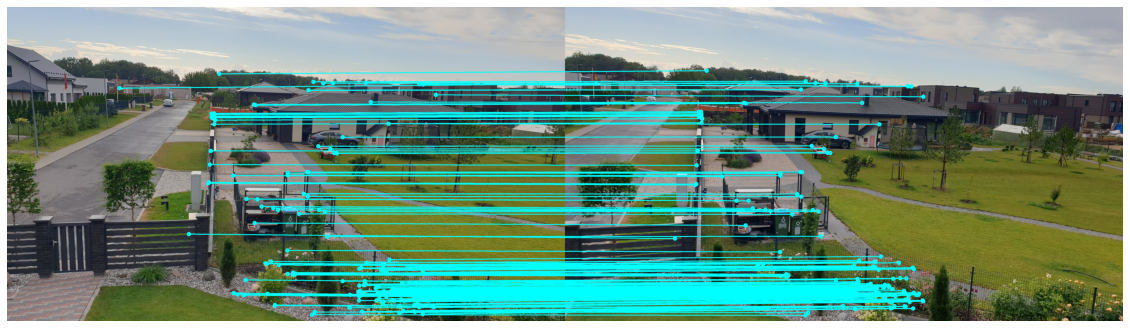

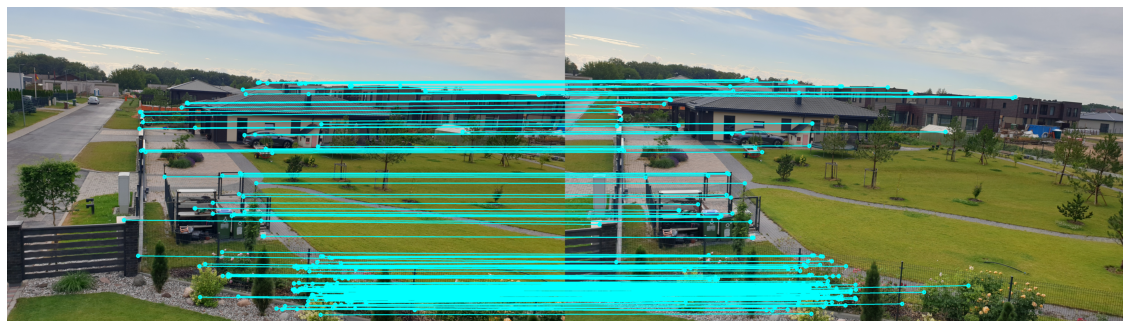

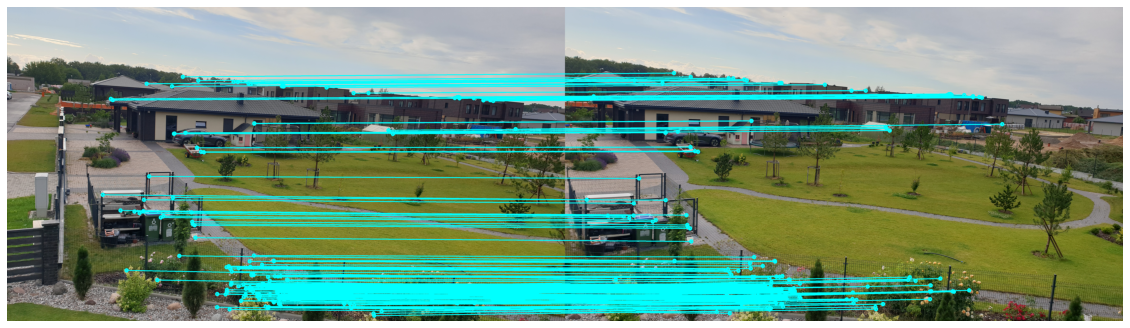

In [108]:
matches_to_show = 200

for img1, p_source, img2, p_target in zip(images[:-1], source_points, images[1:], target_points):
    f = plt.figure(figsize=(20, 10))
    vis = draw_matches(img1, p_source[:matches_to_show], img2, p_target[:matches_to_show])
    plt.axis("off")
    plt.imshow(vis)

## Estimating the homography matrix

After looking at the correspondences, let's stitch the images together! In order to stitch together the images, we need a function to return the 2x9 homography matrix `A_i` matrix for a given 2D correspondence pair `xi_vector` and `xi_prime_vector` (which are 3D homogeneous vectors).

In [109]:
def get_Ai(xi_vector, xi_prime_vector):
    ''' Returns the A_i matrix discussed in the lecture for input vectors.
    
    Args:
        xi_vector (array): the x_i vector in homogeneous coordinates
        xi_vector_prime (array): the x_i_prime vector in homogeneous coordinates
    '''
    assert xi_vector.shape == (3, ) and xi_prime_vector.shape == (3, )

    Ai = np.zeros((2, 9))
    Ai[0, 3:6] = -xi_prime_vector[2] * xi_vector
    Ai[0, 6:9] = xi_prime_vector[1] * xi_vector
    Ai[1, 0:3] = xi_prime_vector[2] * xi_vector
    Ai[1, 6:9] = -xi_prime_vector[0] * xi_vector

    assert(Ai.shape == (2, 9))
    
    return Ai

Using `get_Ai`, write a function `get_A` which returns the A matrix of size 2Nx9:

In [110]:
def get_A(points_source, points_target):
    ''' Returns the A matrix discussed in the lecture.
    
    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image
    '''
    N = points_source.shape[0]

    # Insert your code here
    A = np.vstack([
        get_Ai(src, target) for src, target in zip(points_source, points_target)
    ])
    
    assert(A.shape == (2*N, 9))
    return A

Next, implement the function `get_homography` which returns the homography H for point correspondence pairs. We obtain H by performing the Direct Linear Transformation (DLT) algorithm:

In [111]:
def get_homography(points_source, points_target):
    ''' Returns the homography H.
    
    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image        
    '''

    # Insert your code here
    A = get_A(points_source, points_target)
    _, _, V_T = np.linalg.svd(A)
    H = V_T.T[:, -1].reshape((3, 3))

    assert H.shape == (3, 3)
    
    return H

We need a function which takes in the two images and the calculated homography and it returns the stiched image in a format which we can display easy with matplotlib. This function is provided in the following.

In [112]:
def stitch_images(img1, img2, H):
    ''' Stitches together the images via given homography H.

    Args:
        img1 (array): image 1
        img2 (array): image 2
        H (array): homography
    '''

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min,-y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    H_final = H_translation.dot(H)

    output_img = cv2.warpPerspective(img2, H_final, (x_max-x_min, y_max-y_min))
    
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
    output_img = output_img[translation_dist[1]:rows1+translation_dist[1]:, :]

    # Find top and bottom rows
    top_row = output_img.nonzero()[0].min()
    bottom_row = output_img.nonzero()[0].max()

    top_max = output_img[top_row, :].nonzero()[0].max()
    bottom_max = output_img[bottom_row, :].nonzero()[0].max()
   
    # Cut width
    output_img = output_img[:, :min(top_max, bottom_max)]

    return output_img

With this, we can stitch two images together and see how it looks:

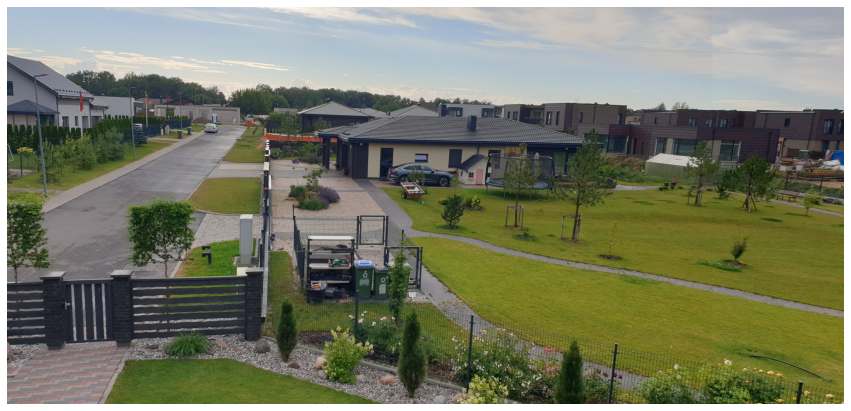

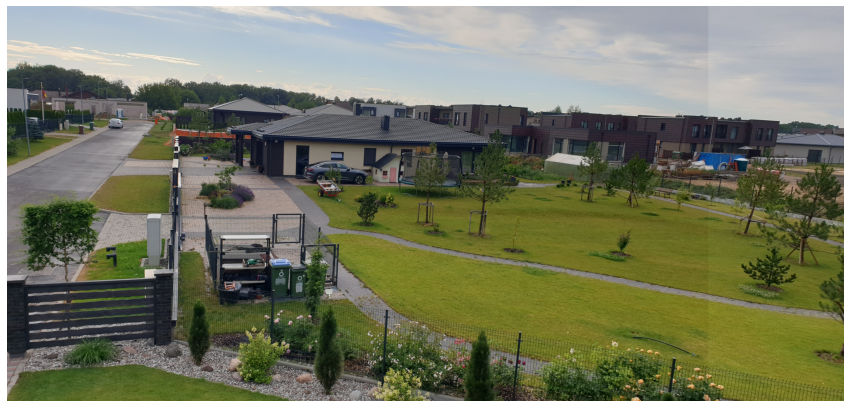

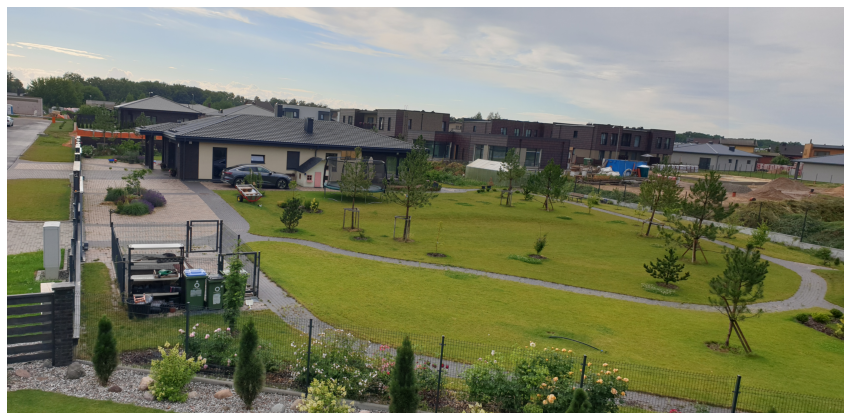

In [113]:
for img1, p_source, img2, p_target in zip(images[:-1], source_points, images[1:], target_points):
    H = get_homography(p_target, p_source)
    stitched_image = stitch_images(img1, img2, H)

    fig = plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(stitched_image)
    plt.show()

Finally, we repeat this process iteratively until all images are stitched together:

In [114]:
def get_panorama(images):
    n_repeats = len(images) - 1

    current_images = images

    for _ in range(n_repeats):
        new_images = []

        keypoint_pairs = [get_keypoints(img1, img2) for img1, img2 in zip(current_images[:-1], current_images[1:])]
        source_points = [pair[0] for pair in keypoint_pairs]
        target_points = [pair[1] for pair in keypoint_pairs]

        for img1, p_source, img2, p_target in zip(current_images[:-1], source_points, current_images[1:], target_points):
            H = get_homography(p_target, p_source)
            stitched_image = stitch_images(img1, img2, H)

            new_images.append(stitched_image)

        current_images = new_images
    
    assert len(current_images) == 1

    return current_images[0]

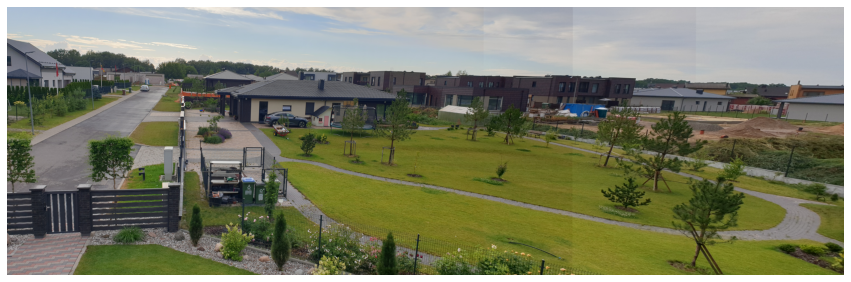

In [116]:
panorama = get_panorama(images)

plt.figure(figsize=(15, 10))
plt.imshow(panorama)
plt.axis("off");

## Conclusion

That's it! We now have a very basic panorama stitcher.

This approach is quite naive and I am sure that real-world algorithms to produce panoramas are much more sophisticated. Therefore, I am open to hear any feedback or suggestions that you may have!